In [3]:

# 필요한 라이브러리 불러오기
import warnings
warnings.filterwarnings("ignore")
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense,LeakyReLU,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve


In [4]:
d = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

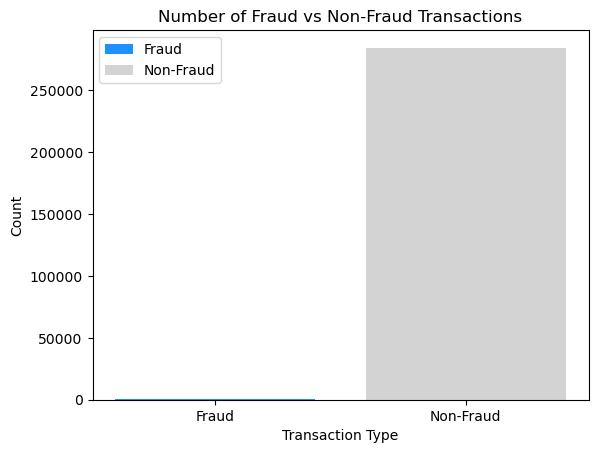

In [5]:
num_nonfraud = np.sum(d['Class'] == 0)  # 'Class' 열에서 값이 0인 비사기 거래의 개수를 계산합니다.
num_fraud = np.sum(d['Class'] == 1)  # 'Class' 열에서 값이 1인 사기 거래의 개수를 계산합니다.

fraud_label = 'Fraud'  # 사기 거래를 나타내는 레이블입니다.
nonfraud_label = 'Non-Fraud'  # 비사기 거래를 나타내는 레이블입니다.

fraud_count = [num_fraud]  # 사기 거래 개수를 리스트에 담습니다.
nonfraud_count = [num_nonfraud]  # 비사기 거래 개수를 리스트에 담습니다.

plt.bar(fraud_label, fraud_count, color='dodgerblue', label='Fraud')  # 사기 거래를 나타내는 막대 그래프를 생성합니다.
plt.bar(nonfraud_label, nonfraud_count, color='lightgrey', label='Non-Fraud')  # 비사기 거래를 나타내는 막대 그래프를 생성합니다.

plt.xlabel('Transaction Type')  # x축 레이블을 설정합니다.
plt.ylabel('Count')  # y축 레이블을 설정합니다.
plt.title('Number of Fraud vs Non-Fraud Transactions')  # 그래프의 제목을 설정합니다.

plt.legend()  # 범례를 표시합니다.
plt.show()  # 그래프를 출력합니다.

In [6]:
data = d.drop(['Time'], axis=1)  # 'Time' 열을 제거한 데이터프레임을 생성합니다.
data['Amount'] = StandardScaler().fit_transform(data[['Amount']])  # 'Amount' 열의 데이터를 표준화(StandardScaler)합니다.
X = data.drop(['Class'],axis=1)  # 'Class' 열을 제외한 나머지 열을 X에 할당합니다.
Y = data.Class  # 'Class' 열을 Y에 할당합니다.


In [7]:
# Autoencoder의 파라미터 설정
input_dim = X.shape[1]  # 입력 차원 설정
encoding_dim = 128  # 인코딩 차원 설정
num_epoch = 30  # 에포크 횟수 설정
batch_size = 256  # 배치 크기 설정

input_layer = Input(shape=(input_dim, ))  # 입력 레이어 정의

# 인코더 레이어 정의
encoder = Dense(encoding_dim,
                activation="tanh",
                activity_regularizer=regularizers.l1(10e-5)
                )(input_layer)  # 인코딩 레이어 설정 및 활성화 함수, 정규화 설정
encoder = BatchNormalization()(encoder)  # 배치 정규화 적용
encoder = LeakyReLU(alpha=0.2)(encoder)  # LeakyReLU 활성화 함수 적용

encoder = Dense(int(encoding_dim/2),
                activation="relu"
                )(encoder)  # 인코딩 레이어 설정 및 활성화 함수
encoder = BatchNormalization()(encoder)  # 배치 정규화 적용
encoder = LeakyReLU(alpha=0.1)(encoder)  # LeakyReLU 활성화 함수 적용

encoder = Dense(int(encoding_dim/4),
                activation="relu"
                )(encoder)  # 인코딩 레이어 설정 및 활성화 함수
encoder = BatchNormalization()(encoder)  # 배치 정규화 적용

# 디코더 레이어 정의
decoder = LeakyReLU(alpha=0.1)(encoder)  # LeakyReLU 활성화 함수 적용
decoder = Dense(int(encoding_dim/4),
                activation='tanh'
                )(decoder)  # 디코딩 레이어 설정 및 활성화 함수
decoder = BatchNormalization()(decoder)  # 배치 정규화 적용
decoder = LeakyReLU(alpha=0.1)(decoder)  # LeakyReLU 활성화 함수 적용

decoder = Dense(int(encoding_dim/2),
                activation='tanh'
                )(decoder)  # 디코딩 레이어 설정 및 활성화 함수
decoder = BatchNormalization()(decoder)  # 배치 정규화 적용
decoder = LeakyReLU(alpha=0.1)(decoder)  # LeakyReLU 활성화 함수 적용

decoder = Dense(input_dim,
                # activation='relu'
                )(decoder)  # 디코딩 레이어 설정

autoencoder = Model(inputs=input_layer,
                    outputs=decoder
                    )  # Autoencoder 모델 정의

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['mae','mse']
                    )  # 모델 컴파일


In [8]:
checkpointer = ModelCheckpoint(filepath="autoencoder_model.h5",
                               verbose=0,
                               save_best_only=True
                               )


In [9]:
history = autoencoder.fit(X, 
                          X,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          verbose=1, 
                          callbacks=[checkpointer]
                          ).history


Epoch 1/30
1113/1113 [==============================] - 10s 6ms/step - loss: 0.3698 - mae: 0.3600 - mse: 0.3652
Epoch 2/30
1113/1113 [==============================] - 6s 6ms/step - loss: 0.1518 - mae: 0.2349 - mse: 0.1472
Epoch 3/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.1060 - mae: 0.1933 - mse: 0.1015
Epoch 4/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0851 - mae: 0.1688 - mse: 0.0807
Epoch 5/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0736 - mae: 0.1541 - mse: 0.0693
Epoch 6/30
1113/1113 [==============================] - 7s 7ms/step - loss: 0.0686 - mae: 0.1441 - mse: 0.0642
Epoch 7/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0606 - mae: 0.1353 - mse: 0.0563
Epoch 8/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0582 - mae: 0.1309 - mse: 0.0539
Epoch 9/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0541 - mae: 0.1251 - mse: 0.0499


* autoencoder 모델에 대해 fit 메서드를 호출하여 모델을 훈련시킵니다.
* 첫 번째 인자인 X는 입력 데이터입니다. 여기서는 입력과 출력이 동일한 값을 가지므로 X를 두 번 사용했습니다.
* epochs 매개변수에는 에포크 횟수를 설정합니다. 이전에 설정한 num_epoch 값을 사용합니다.
* batch_size 매개변수에는 배치 크기를 설정합니다. 이전에 설정한 batch_size 값을 사용합니다.
* shuffle 매개변수를 True로 설정하면, 각 에포크마다 데이터를 섞습니다.
* 주석 처리된 validation_data는 모델 훈련 과정에서 검증 데이터를 사용할 경우에 설정합니다.
* verbose 매개변수는 훈련 과정의 진행 상황 출력을 제어하는 것으로, 1로 설정하면 출력합니다.
* callbacks 매개변수에는 콜백 함수를 리스트로 전달합니다. 여기서는 checkpointer를 사용하여 모델 가중치를 저장하는 콜백을 등록했습니다.
* history 변수에는 훈련 과정의 손실 및 평가 지표 값을 저장합니다. .history 속성을 사용하여 접근할 수 있습니다.

이렇게 작성된 코드는 모델을 훈련시키고, 훈련 과정에서 최적의 모델 가중치를 "autoencoder_model.h5" 파일로 저장하는 작업을 수행합니다.

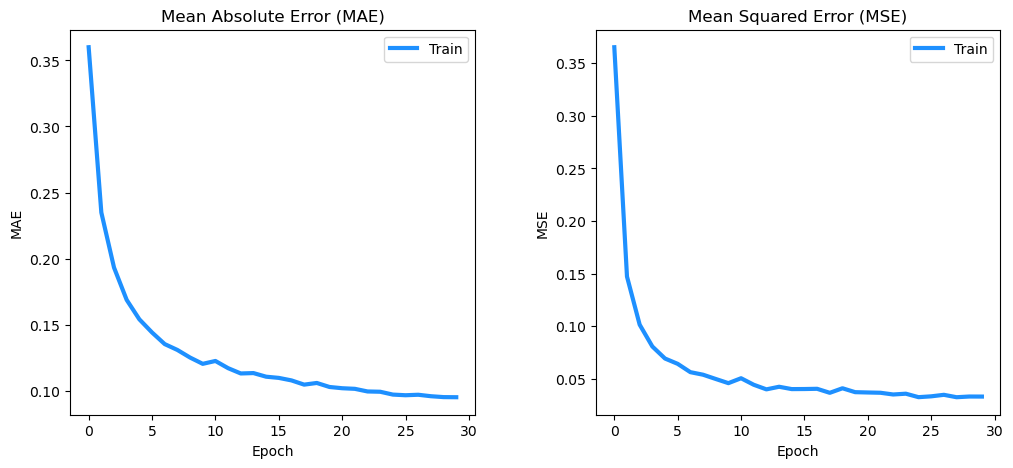

In [10]:
# MAE 그래프
plt.subplot(121)
plt.plot(history['mae'], c='dodgerblue', lw=3)
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

# MSE 그래프
plt.subplot(122)
plt.plot(history['mse'], c='dodgerblue', lw=3)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

plt.subplots_adjust(wspace=0.3)  # 그래프 사이 간격 조정
plt.gcf().set_size_inches(12, 5)  # 그래프의 가로 길이 조정

plt.show()


위 코드는 모델 훈련 과정에서의 손실 함수(MSE), 평균 절대 오차(MAE), 평균 제곱 오차(MSE)의 변화를 그래프로 나타내는 작업입니다.

* MAE 그래프: 훈련 과정에서 MAE 값의 변화를 나타냅니다.
* MSE 그래프: 훈련 과정에서 MSE 값의 변화를 나타냅니다.

In [11]:
# 훈련된 오토인코더를 사용하여 테스트 세트를 재구성합니다.
pred_X = autoencoder.predict(X)

# 재구성 오차(MSE와 MAE)를 계산합니다.
mse_X = np.mean(np.power(X - pred_X, 2), axis=1)
mae_X = np.mean(np.abs(X - pred_X), axis=1)

# 재구성 오차를 데이터 DataFrame에 추가합니다.
data['mse_X'] = mse_X
data['mae_X'] = mae_X

# Top-N 정확도 평가
n = 1000
df = data.sort_values(by='mae_X', ascending=False)
top_n_df = df.head(n)
accuracy = top_n_df[top_n_df['Class'] == 1].shape[0] / n
print('Top-{} 정확도: {}'.format(n, accuracy))


8901/8901 [==============================] - 13s 1ms/step
Top-1000 정확도: 0.329


위 코드는 훈련된 오토인코더를 사용하여 테스트 세트를 재구성합니다. 재구성 오차(MSE와 MAE)를 계산하고, 이를 데이터 DataFrame에 추가합니다. 그 후, 상위 N개의 샘플을 추출하여 해당 샘플들 중 사기 클래스의 비율을 계산하여 Top-N 정확도를 평가합니다.

* pred_X: 오토인코더를 사용하여 입력 데이터 X의 재구성을 예측한 값
* mse_X: 입력 데이터 X와 재구성된 값 pred_X 사이의 평균 제곱 오차(MSE)
* mae_X: 입력 데이터 X와 재구성된 값 pred_X 사이의 평균 절대 오차(MAE)
* n: 상위 N개의 샘플을 선택하는데 사용되는 값
* df: 데이터를 mae_X 기준으로 내림차순으로 정렬한 DataFrame
* top_n_df: df에서 상위 N개의 샘플을 추출한 DataFrame
* accuracy: 상위 N개의 샘플 중 사기 클래스의 비율, 즉 Top-N 정확도

16/16 [==============================] - 0s 2ms/step


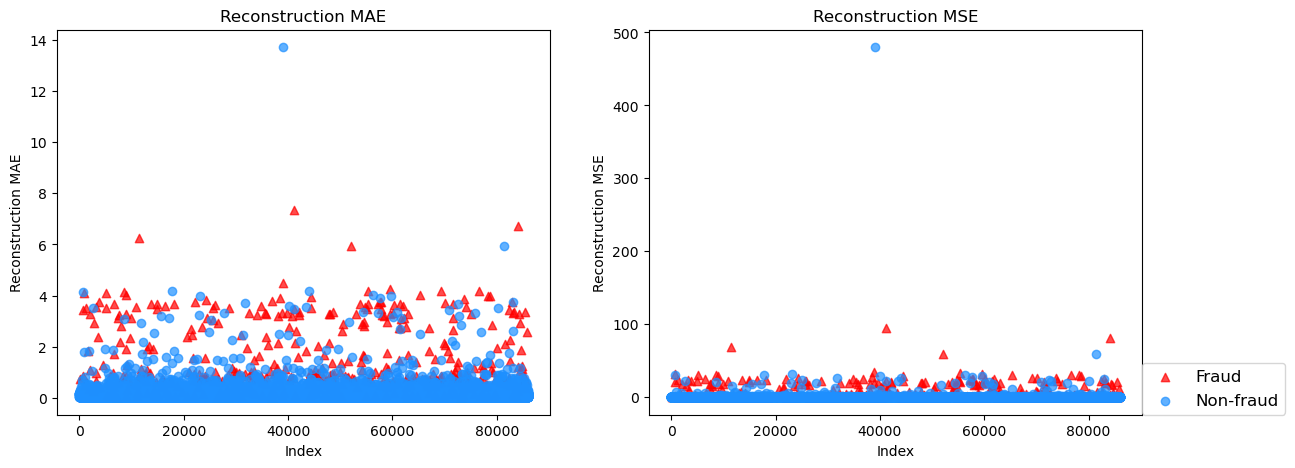

In [12]:
# 'Class'가 0인 행, 즉 부정 행위가 아닌 행을 추출하고, 7:3 비율로 훈련셋과 테스트셋으로 분리
mask = (data['Class'] == 0)
X_train, X_test = train_test_split(X, test_size=0.3, random_state=520)

# 'Class'가 1인 행, 즉 부정 행위를 한 행을 추출하여 테스트셋의 일부로 설정
X_fraud = X[~mask]


# 훈련된 autoencoder를 이용하여 테스트셋을 재구성
pred_test  = autoencoder.predict(X_test)
pred_fraud = autoencoder.predict(X_fraud)


# 재구성 오차인 MSE(평균 제곱 오차)와 MAE(평균 절대 오차) 계산
mse_test = np.mean(np.power(X_test - pred_test, 2), axis=1)
mse_fraud = np.mean(np.power(X_fraud - pred_fraud, 2), axis=1)
mae_test = np.mean(np.abs(X_test - pred_test), axis=1)
mae_fraud = np.mean(np.abs(X_fraud - pred_fraud), axis=1)
mse_df = pd.DataFrame()
mse_df['Class'] = [0] * len(mse_test) + [1] * len(mse_fraud)
mse_df['MSE'] = np.hstack([mse_test, mse_fraud])
mse_df['MAE'] = np.hstack([mae_test, mae_fraud])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)


# 테스트셋에서 정상 샘플과 부정 행위 샘플의 재구성 오차 MAE와 MSE를 그림으로 표현
markers = ['o', '^']
markers = ['o', '^']
colors = ['dodgerblue', 'red']
labels = ['Non-fraud', 'Fraud']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MAE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE')
plt.xlabel('Index')

plt.subplot(122)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12)
plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE')
plt.xlabel('Index')
plt.show()


MAE와 MSE를 보면, 양성 및 음성 샘플 간에 상당한 차이가 있음을 알 수 있습니다. 이는 이 알고리즘이 우수한 이상 탐지 능력을 가지고 있음을 증명합니다. 그러나 일부 정상 샘플은 여전히 이상 탐지를 통해 분리하기 어렵습니다.